# Capstone Project: Life in the "New Normal"
---

#### Organization of Project Notebooks:
- Notebook #1: [Problem Statement & Webscraping](./01_problem_statement_and_web_scraping.ipynb)
- Notebook #2: [Data Cleaning & Exploratory Data Analysis](./02_data_cleaning_and_eda.ipynb)
- **Notebook #3: Preprocessing & Modelling**
    - **Notebook #3-1: Preprocessing & Sentiment Analysis (current notebook)**
    - Notebook #3-2: [Building Pre-trained LSTM RNN Model for Sentiment Analysis](./03-2_building_pretrained_lstm_model.ipynb) 
- Notebook #4: [Topic Modelling & Conclusion](./04_topic_modelling_and_conclusion.ipynb)
- Notebook #5: [Plotly & Dash Visualization](./05_plotly_and_dash.ipynb)

## Notebook #3-1: Preprocessing & Sentiment Analysis

### Contents
1. [Introduction](#1.-Introduction)
2. [Preprocessing](#2.-Preprocessing)
3. [Sentiment Analysis](#3.-Sentiment-Analysis)

### 1. Introduction

In this notebook, I will be preprocessing the cleaned tweets obtained from the [previous notebook](./02_data_cleaning_and_eda.ipynb), via tokenization and lemmatization. Thereafter, I will be using a few libraries to perform Sentiment Analysis on the tweets, which include VADER, TextBlob and a pre-trained LSTM RNN model.

In [99]:
# import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

import nltk
from nltk.tokenize import word_tokenize      
from nltk.stem import WordNetLemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer     
from textblob import TextBlob

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
# import the dataframe
sg_tweets_cleaned_df = pd.read_csv('../datasets/sg_tweets_cleaned_2021.csv')

### 2. Preprocessing
In this section, I will be passing the cleaned tweets through tokenization and lemmatization, to return the tokenized words in their lemma form, i.e. similar to the base/dictionary form of a word. Lemmatizing is preferred over stemming, as it is less likely to result in irregularities in English. 

In addition, stop words will not be removed from the tweet, as the libraries that will be utilised for Sentiment Analysis take into consideration every word in a tweet to deduce its sentiment. 

In [3]:
# instantiate the lemmatizier
lemmatizer = WordNetLemmatizer()

# set up the lemmatizer
lemmatized_tweets = []
for tweet in sg_tweets_cleaned_df['cleaned_tweet']:
    word_tokens = word_tokenize(tweet)
    
    tweet = [lemmatizer.lemmatize(word) for word in word_tokens]
    lemmatized_tweets.append(' '.join(tweet))
    
# append the lemmatized tweets to the DataFrame
sg_tweets_cleaned_df['lemmatized_tweet'] = lemmatized_tweets

In [4]:
# copy into a new dataframe
sg_tweets_lem_df = sg_tweets_cleaned_df.copy()

# view the top 5 rows
sg_tweets_lem_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end


In [5]:
# save the lemmatized tweets
sg_tweets_lem_df.to_csv('../datasets/sg_tweets_cleaned_lem_wso_2021.csv', index=False)

### 3. Sentiment Analysis

In this section, I will be carrying out the Sentiment Analysis of the tweets, to determine the sentiment for tweets in Singapore from January to July 2021. 

As the tweets are unlabelled, I will be utilising a combination of libraries that do not require training data, as well as a model that is partially trained, to predict the sentiment. These include: 
- NLTK's VADER
- TextBlob
- LSTM RNN

### 3.1 Sentiment Analysis using NLTK's VADER

VADER, which refers to Valence Aware Dictionary for sEntiment Reasoning, is a text sentiment analysis model that identifies the polarity (i.e. positive or negative) and intensity (i.e. strength) of an emotion, based on the lexicons of sentiment-related words (source: [Singh, Dec 2020](https://analyticsindiamag.com/sentiment-analysis-made-easy-using-vader/)).

As VADER does not require any training data, I will be utilising VADER to determine if a tweet's sentiment is classified as positive or negative based on its compound score. The compound score is a metric that computes the sum of all lexicon ratings that have been normalized between -1 (most negative) and +1 (most positive).

In [6]:
# instantiate vader
sent = SentimentIntensityAnalyzer()

# compute the compound score
sg_tweets_lem_df['sent_compound'] = [sent.polarity_scores(x)['compound'] for x in sg_tweets_lem_df['lemmatized_tweet']]

In [7]:
# include a sentiment label where:
# compound score>=0 is positive
# compound score<0 is negative

def sent_label(sent_compound):
    if sent_compound >= 0:
        return 'positive'
    else:
        return 'negative'

# create a new column to store the sentiment label 
sg_tweets_lem_df['sent_label'] = sg_tweets_lem_df['sent_compound'].apply(sent_label)

In [8]:
# view the top 5 rows
sg_tweets_lem_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel,0.4588,positive
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...,0.4996,positive
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...,0.0000,positive
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast,0.0000,positive
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end,0.0000,positive


[Text(0.5, 0, 'Sentiment label'), Text(0, 0.5, 'Number of tweets')]

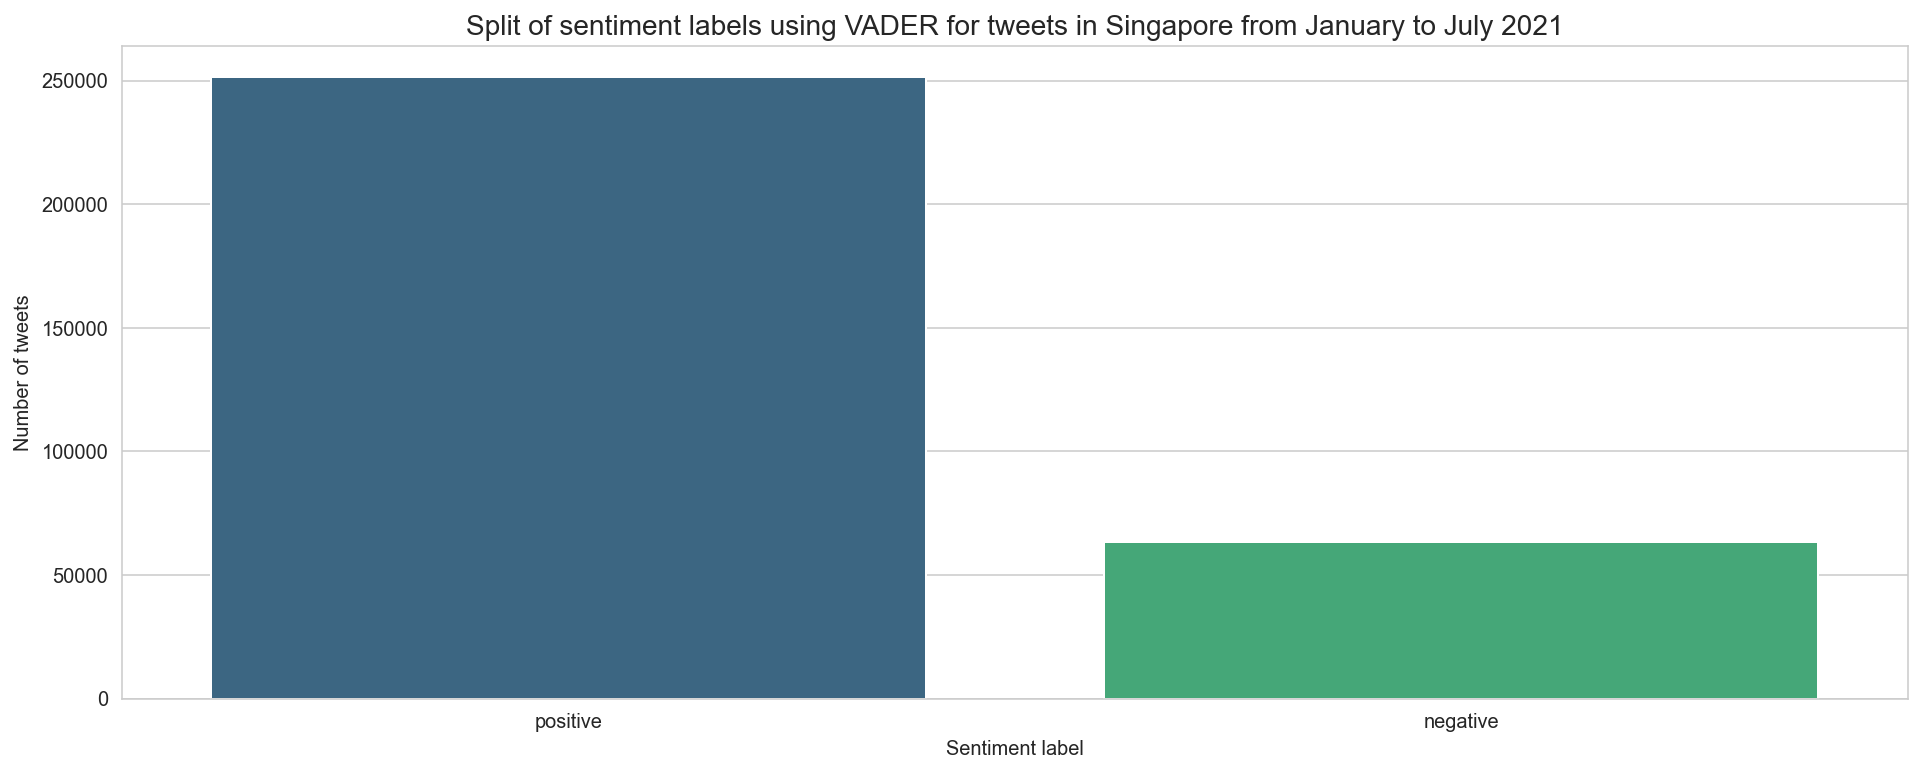

In [9]:
# view the count of sentiment label
plt.figure(figsize=(16,6))
plt.title('Split of sentiment labels using VADER for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.countplot(x='sent_label', data=sg_tweets_lem_df, palette='viridis')
ax.set(xlabel='Sentiment label', ylabel='Number of tweets') 

As tweets with compound scores that are zero and above are classified as positive, it can be observed that the proportion of positive tweets far outweighs the proportion of negative tweets by more than three times.

[Text(0.5, 0, 'Sentiment compound score'), Text(0, 0.5, 'Number of tweets')]

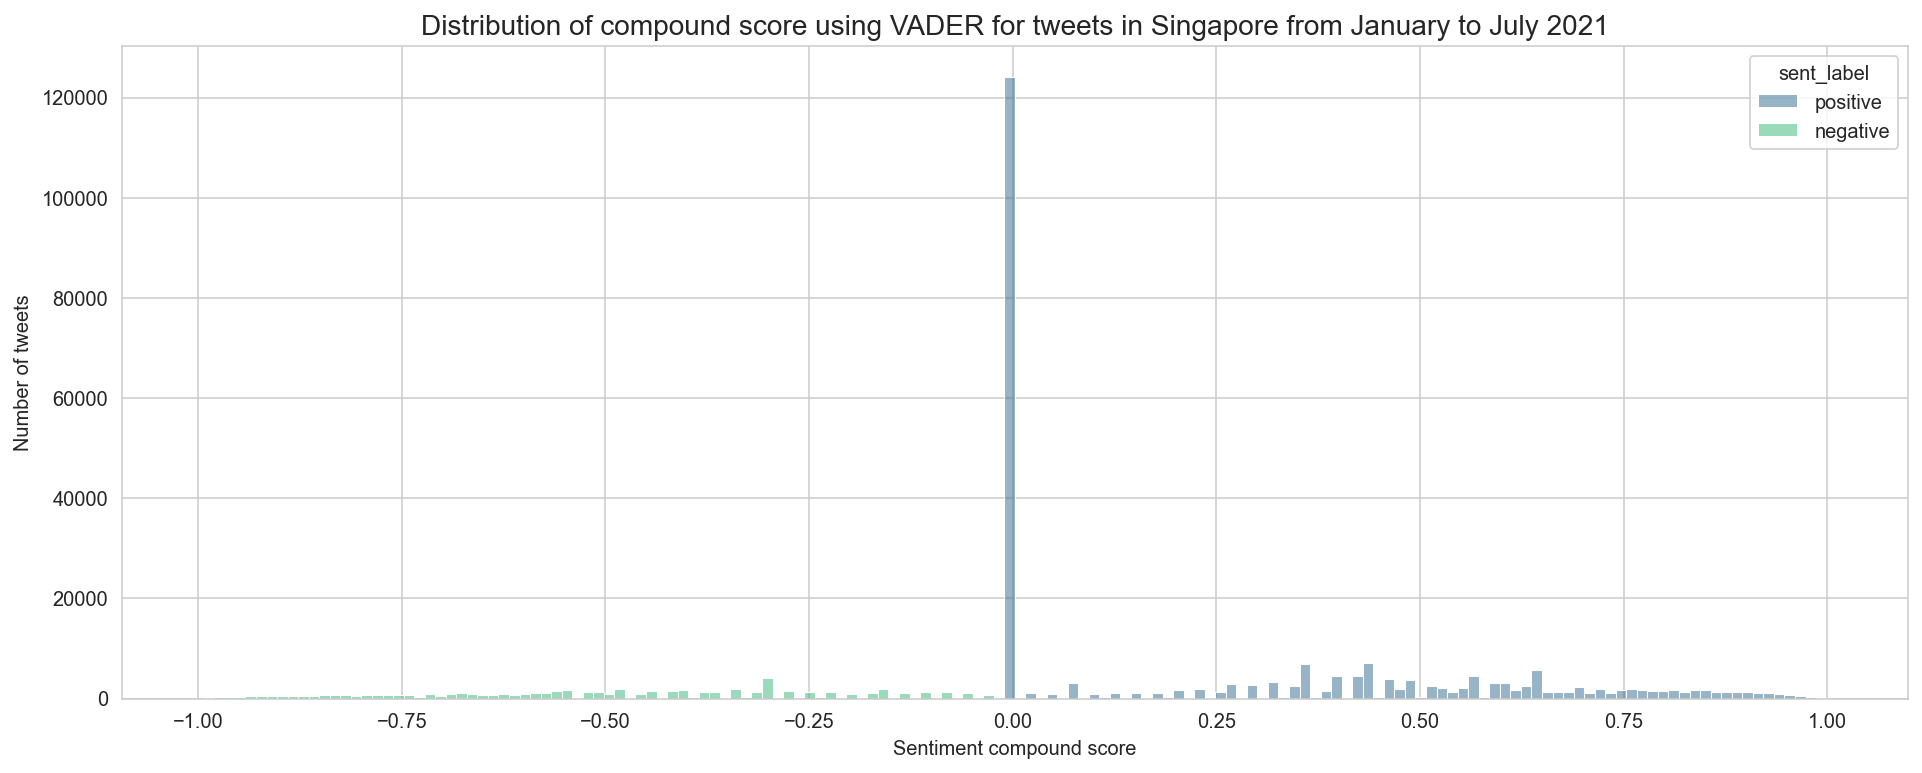

In [10]:
# create the plot based on compound score
plt.figure(figsize=(16,6))
plt.title('Distribution of compound score using VADER for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.histplot(data=sg_tweets_lem_df, x='sent_compound', hue='sent_label', palette='viridis')
ax.set(xlabel='Sentiment compound score', ylabel='Number of tweets')  

From the distribution of compound scores, it can be seen that close to one third of the tweets have a compound score of zero. The remaining tweets with positive sentiment labels are in the range of 0.25 to 0.65 (more prominent spikes around 0.35), whereas those with negative sentiment labels tend to congregate around -0.25. 

On the use of NLTK's VADER, it is efficient in determining sentiment as it does not require any training data. Besides, it is optimised for social media text such as Twitter and Facebook, as it can understand texts containing emoticons, slangs, conjunctions, punctuations, etc. However, one of its downside is that it only looks at individual words and ignores the context in which the words are used.

Let's continue exploring with the next library – TextBlob.

### 3.2 Sentiment Analysis using TextBlob
    
TextBlob is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks which include (but not limited to) part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, etc. (source: [TextBlob, 2020](https://textblob.readthedocs.io/en/dev/quickstart.html)).

Similar to VADER, TextBlob does not require any training data. Therefore, I will be utilising TextBlob to determine if a tweet's sentiment is classified as positive or negative based on its polarity score. The polarity score is a float which lies in the range of [-1,1], where -1 refers to a negative statement and 1 refers to a positive statement. 

Concurrently, the subjectivity score will be obtained. Subjectivity is also a float in the range of [0,1], where subjective sentences may refer to personal opinion or judgment whereas objective sentences refer to factual information. 

In [11]:
# compute the polarity score
sg_tweets_lem_df['tb_polarity'] = sg_tweets_lem_df['lemmatized_tweet'].apply(lambda x:
                                                                             TextBlob(x).sentiment.polarity)

# compute the subjectivity score
sg_tweets_lem_df['tb_subjectivity'] = sg_tweets_lem_df['lemmatized_tweet'].apply(lambda x:
                                                                                 TextBlob(x).sentiment.subjectivity)

In [12]:
# include a sentiment label where:
# polarity score>=0 is positive
# compound score<0 is negative

def tb_label(tb_polarity):
    if tb_polarity >= 0:
        return 'positive'
    else:
        return 'negative'

# create a new column to store the sentiment label 
sg_tweets_lem_df['tb_label'] = sg_tweets_lem_df['tb_polarity'].apply(sent_label)

In [13]:
# view the top 5 rows
sg_tweets_lem_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label,tb_polarity,tb_subjectivity,tb_label
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel,0.4588,positive,0.200000,0.300000,positive
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...,0.4996,positive,-0.197222,0.613889,negative
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...,0.0000,positive,0.000000,0.000000,positive
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast,0.0000,positive,0.000000,0.000000,positive
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end,0.0000,positive,0.000000,0.000000,positive


[Text(0.5, 0, 'Sentiment label'), Text(0, 0.5, 'Number of tweets')]

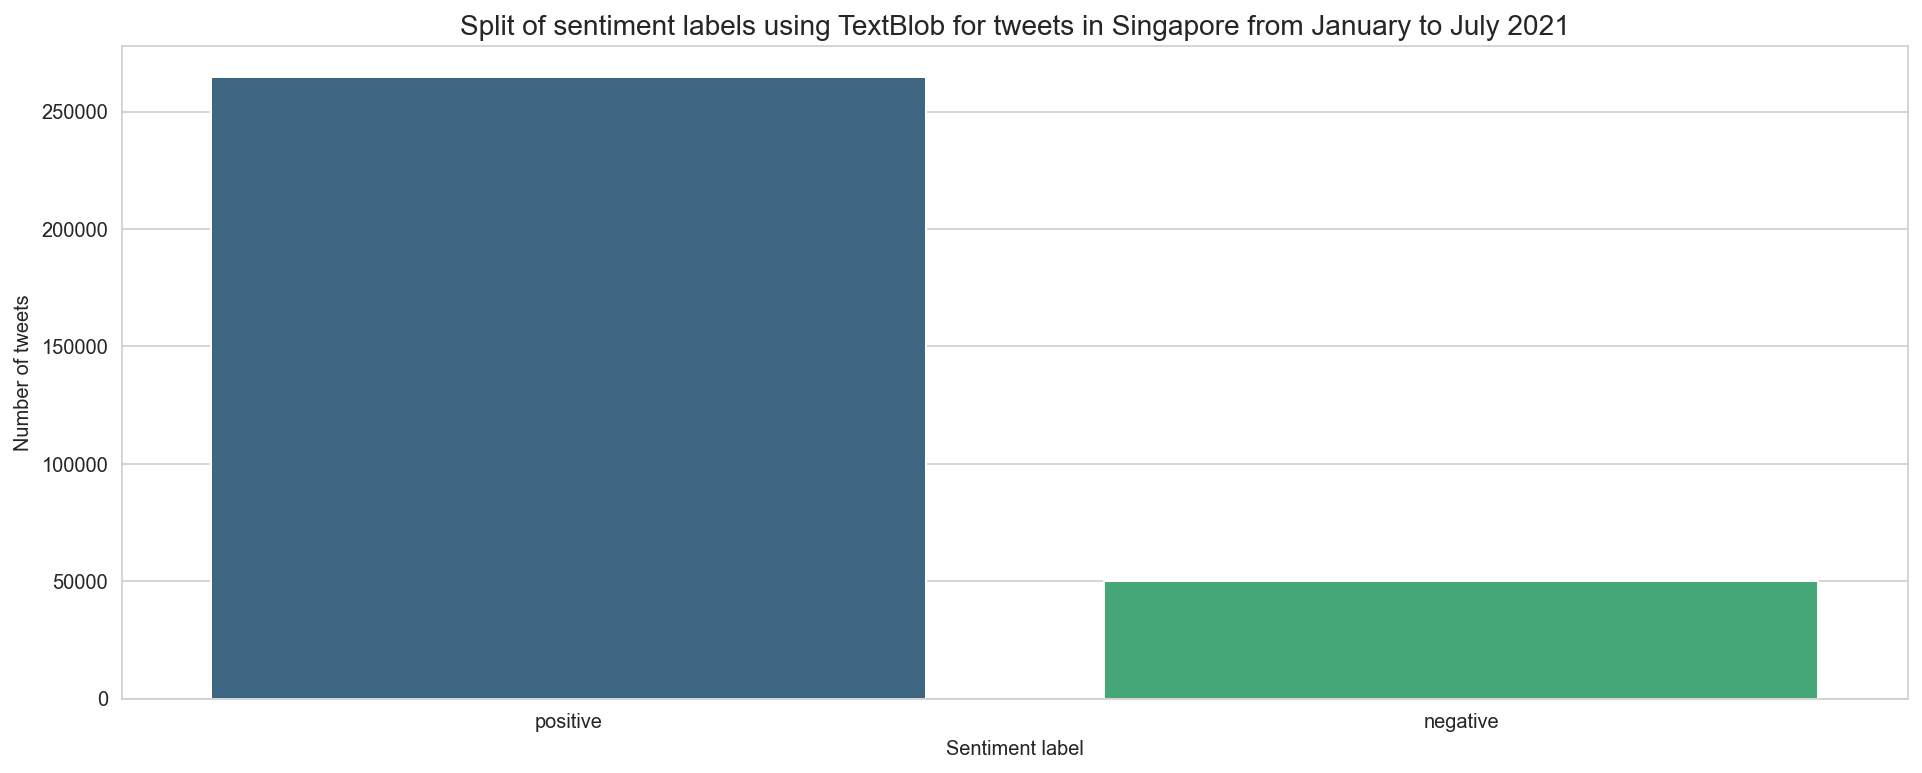

In [14]:
# view the count of sentiment label
plt.figure(figsize=(16,6))
plt.title('Split of sentiment labels using TextBlob for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.countplot(x='tb_label', data=sg_tweets_lem_df, palette='viridis')
ax.set(xlabel='Sentiment label', ylabel='Number of tweets') 

Similar to VADER, as tweets with compound scores that are zero and above are classified as positive, it can be observed that the proportion of positive tweets is five times more than the proportion of negative tweets.

However, as compared to VADER, TextBlob seems to have classified more tweets as having positive sentiment than negative sentiment.

[Text(0.5, 0, 'Sentiment polarity score'), Text(0, 0.5, 'Number of tweets')]

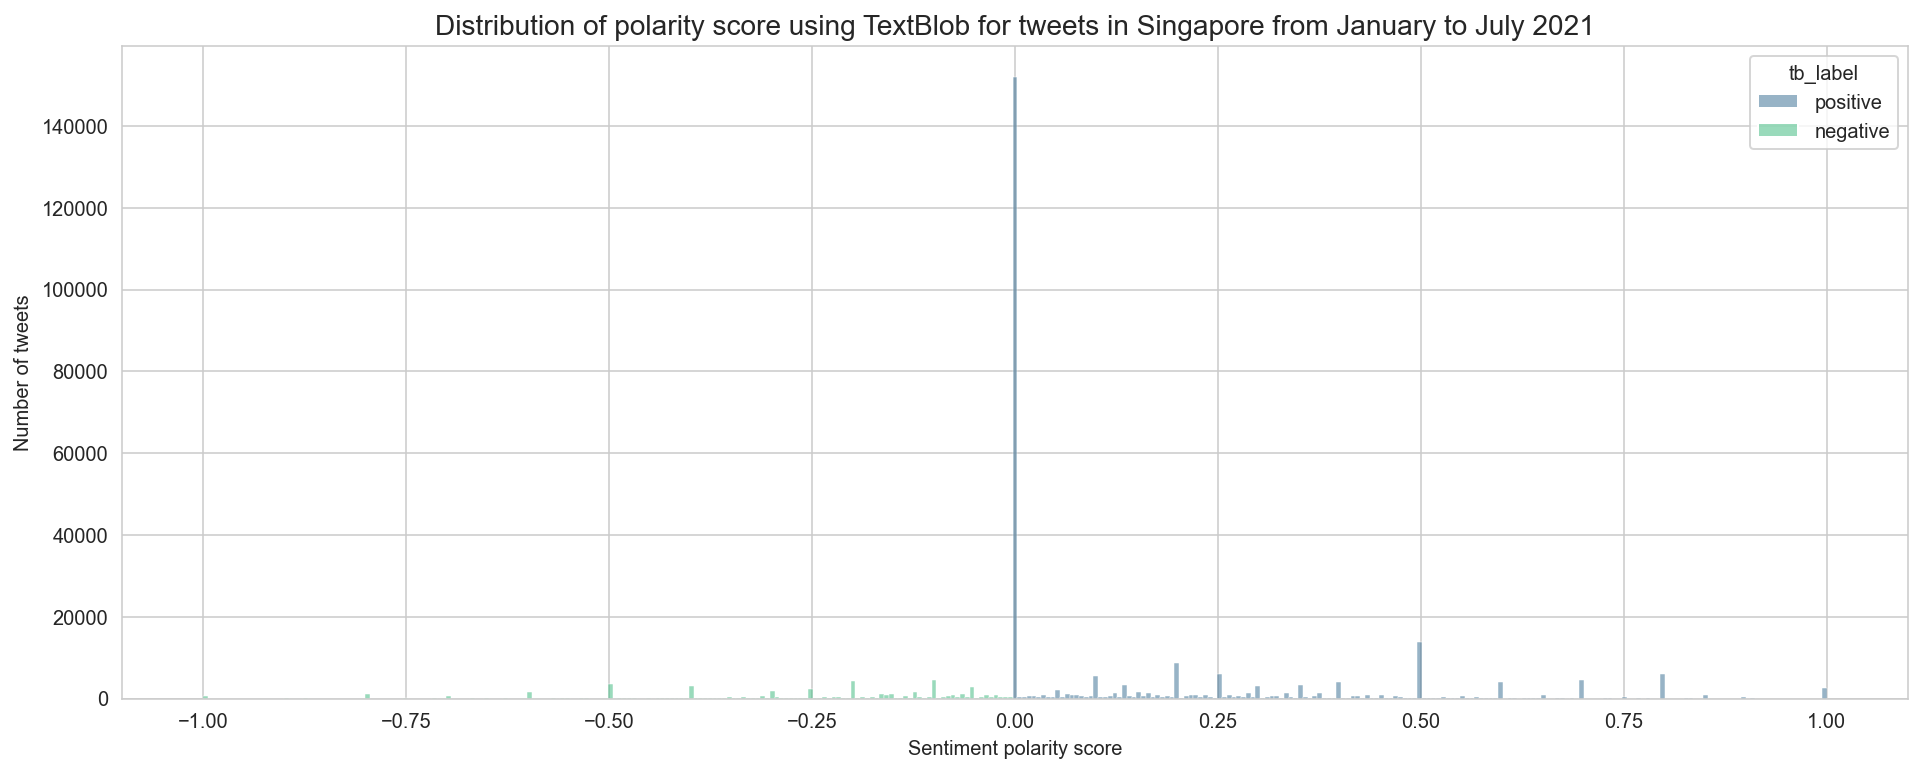

In [15]:
# create the plot based on polarity score
plt.figure(figsize=(16,6))
plt.title('Distribution of polarity score using TextBlob for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.histplot(data=sg_tweets_lem_df, x='tb_polarity', hue='tb_label', palette='viridis')
ax.set(xlabel='Sentiment polarity score', ylabel='Number of tweets')  

From the distribution of polarity scores, it can be seen that more than one third of the tweets have a polarity score of zero. The remaining tweets with positive sentiment labels are in the range of 0.25 to 0.50, whereas those with negative sentiment labels tend to congregate around -0.25 to 0.

[Text(0.5, 0, 'Sentiment subjectivity score'),
 Text(0, 0.5, 'Number of tweets')]

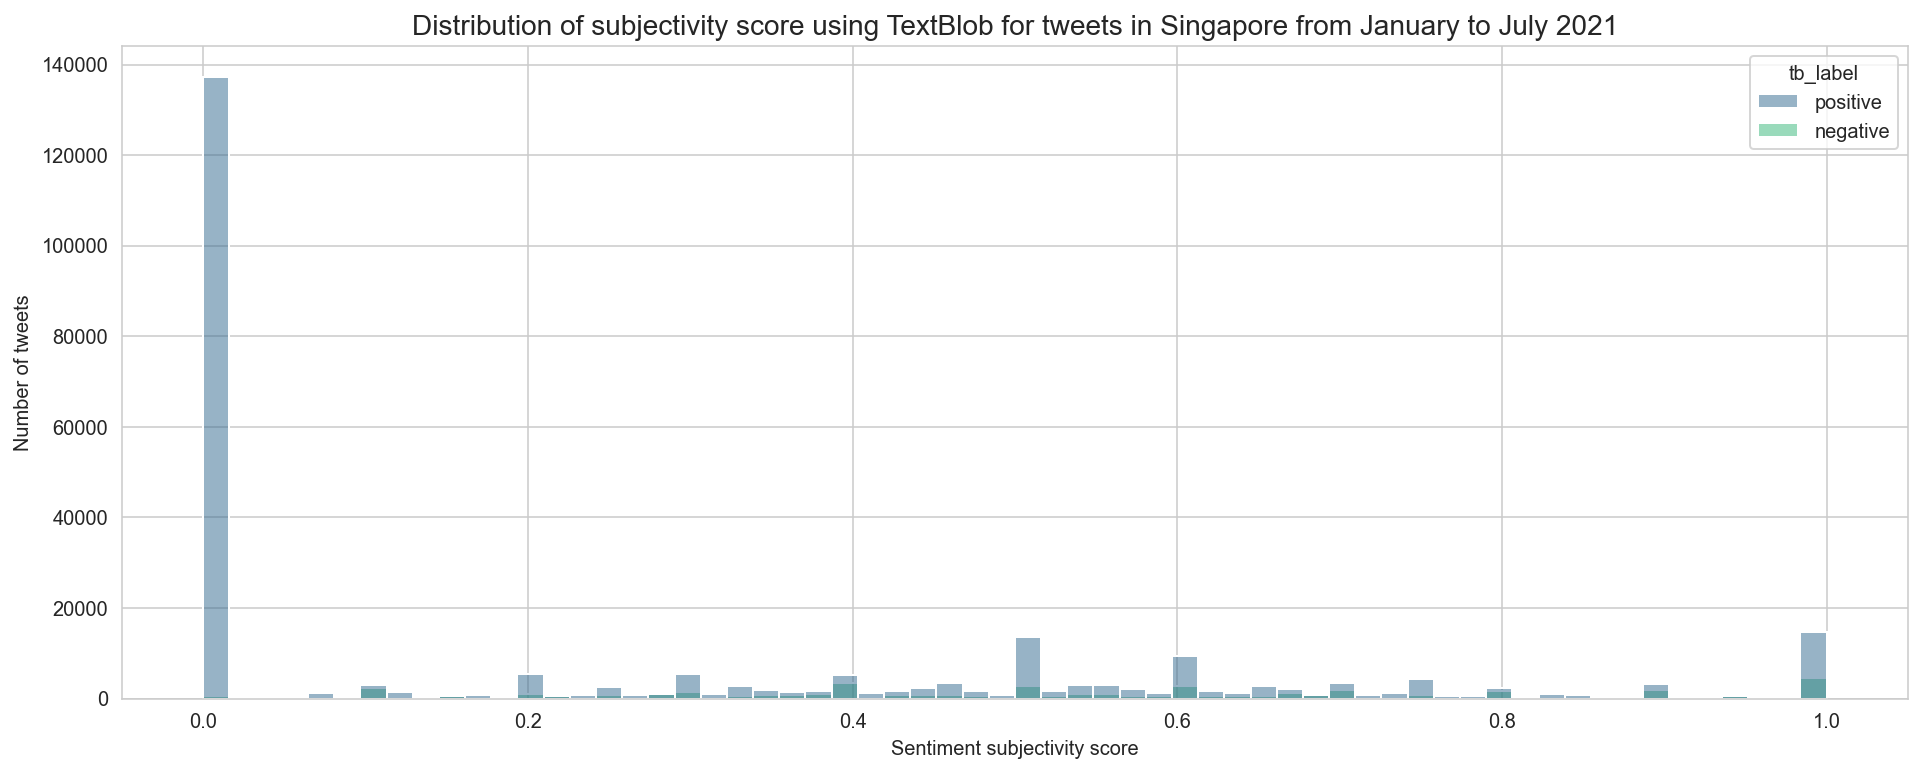

In [16]:
# create the plot based on subjectivity score
plt.figure(figsize=(16,6))
plt.title('Distribution of subjectivity score using TextBlob for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.histplot(data=sg_tweets_lem_df, x='tb_subjectivity', hue='tb_label', palette='viridis')
ax.set(xlabel='Sentiment subjectivity score', ylabel='Number of tweets')  

From the distribution of subjectivity scores, it can be observed that close to 140,000 tweets are identified with subjectivity score of zero, indicating that they are likely to be factual information. Most of them fall under tweets detected to have positive sentiment labels. On the other hand of the spectrum, close to 20,000 tweets are identified with subjectivity score of 1.0, with majority having positive sentiment labels.

On the use of TextBlob, while it is capable of assigning polarity to words and obtaining an average score, it will ignore words that it is not able to interpret. Since tweets in Singapore may contain slangs and Singlish, this may not be captured in TextBlob's sentiment prediction. In addition, TextBlob does not take into consider the sequence of the words, which can be crucial in detecting the true sentiment of the text. 

Let's continue exploring with the next library – LSTM RNN.

### 3.3 Sentiment Analysis using Long Short-Term Memory (LSTM)

Having utilised NLTK's VADER and TextBlob to predict the sentiment of the tweets, I'm keen to employ a Neural Network that not only evaluates the choice of words used, but also considers the sequence of words in a sentence. 

This leads me to Long Short-Term Memory (LSTM), which is an advanced Recurrent Neural Network (RNN) that takes into consideration the sequence of the words in a sequence, complements the traditional feed-forward networks where inputs are multiplied by a weight and bias is added until an output from the last layer is obtained. Besides, LSTM is able to handle the diminishing gradient issue faced in RNN, by capturing long-term dependencies and relations in the sequential data and updating the network parameters (souce: [Saxena, March 2021](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/)). 

As employing a Neural Network requires labelled training data, I will be adopting a semi-supervised learning approach to predict the sentiments of the tweets (for more details, refer to this [notebook]((./03-2_building_pretrained_lstm_model.ipynb))): 
- Firstly, I have built a LSTM RNN model using 500,000 labelled tweets from the Sentiment140 dataset, which originally contains 1,600,000 tweets annotated with 'positive' or 'negative' sentiment (source: [Sentiment140, 2021](http://help.sentiment140.com/for-students)). 
- Next, the LSTM RNN model built is utilised to predict the sentiment of Singapore tweets in the odd months of 2021 (January (1), March (3), May (5) and July (7)).
- With the predicted sentiment labels for Singapore tweets in the odd months of 2021, I have built a new LSTM RNN model. 


In this section, the new LSTM RNN model trained on Singapore tweets in the odd months (January (1), March (3), May (5) and July (7)) will be employed to predict the sentiments for tweets in the even months (February (2), April (4) and June (6)). Thereafter, both sets of predicted labels will be merged. 

In [17]:
# load the model created from training SG tweets in odd months
lstm_model = load_model('../models/lstm_sg_odd_wso_model.h5')

In [18]:
# extract only tweets in Feb, Apr, Jun 
sg_tweets_even_df = sg_tweets_lem_df[sg_tweets_lem_df['month'].isin([2,4,6])].copy()

# assign tweets to X 
X = sg_tweets_even_df['lemmatized_tweet']

In [19]:
# instantiate tokenizer
tokenizer = Tokenizer()

# fit tokenizer on lemmatized tweet
tokenizer.fit_on_texts(sg_tweets_even_df['lemmatized_tweet'].values)

# assign X
X = tokenizer.texts_to_sequences(sg_tweets_even_df['lemmatized_tweet'].values)

# add pad_sequences to X
X = pad_sequences(X)

In [20]:
# apply model to X to predict y classes
y_even = lstm_model.predict_classes(X)

In [21]:
# to add the classes to the dataframe
sg_tweets_even_df['lstm_even_label'] = y_even

# view top 5 rows
sg_tweets_even_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label,tb_polarity,tb_subjectivity,tb_label,lstm_even_label
53493,1365813547326984199,2021-02-28 07:58:19,and I’m talking to yooouuuuu ooooo ooooo 🎶🧑‍🚀🚀...,en,"['spaceman', 'snl']",66206299,carlajonas,4,0,0,Singapore,2021-02-28,2,2021,7,227,38,2,1,and m talking to yooouuuuu ooooo ooooo made ne...,and m talking to yooouuuuu ooooo ooooo made ne...,0.1027,positive,0.257576,0.599327,positive,0
53494,1365813346394656770,2021-02-28 07:57:32,Just posted a photo @ Singapore https://t.co/...,en,[],18243152,SUPERADRIANME,0,0,1,Singapore,2021-02-28,2,2021,7,56,7,0,0,just posted photo singapore,just posted photo singapore,0.0000,positive,0.000000,0.000000,positive,1
53495,1365813286524964865,2021-02-28 07:57:17,Morning! ☀️ @officialtwt_OSW #ONGSEONGWU #옹성우...,en,"['ongseongwu', '옹성우']",1286319986802176000,KangEuiOng,0,0,0,Singapore,2021-02-28,2,2021,7,71,6,2,1,morning,morning,0.0000,positive,0.000000,0.000000,positive,1
53496,1365813009742848000,2021-02-28 07:56:11,@sojinnieee_ your faves in one shot hahaha,en,[],51262719,sirkillet,1,1,0,Singapore,2021-02-28,2,2021,7,42,7,0,1,your faves in one shot hahaha,your faves in one shot hahaha,0.5574,positive,0.200000,0.400000,positive,0
53497,1365811757281869827,2021-02-28 07:51:13,"beach, distant. @ Tanjong Beach Club https://...",en,[],29119311,theMARlion,0,0,0,Singapore,2021-02-28,2,2021,7,61,7,0,0,beach distant tanjong beach club,beach distant tanjong beach club,0.0000,positive,-0.100000,0.350000,negative,1


In [22]:
# map 1 as positive and 0 as negative
sg_tweets_even_df['lstm_even_label'] = sg_tweets_even_df['lstm_even_label'].map({1:'positive', 0:'negative'})

# view bottom 5 rows
sg_tweets_even_df.tail()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label,tb_polarity,tb_subjectivity,tb_label,lstm_even_label
276937,1399517941952090117,2021-06-01 08:07:33,Just posted a photo @ SECTS SHOP https://t.co...,en,[],1923583964,SectsShop,0,0,0,Singapore,2021-06-01,6,2021,8,57,8,0,0,just posted photo sects shop,just posted photo sect shop,0.0000,positive,0.000000,0.0000,positive,positive
276938,1399517749315915783,2021-06-01 08:06:47,#bitcoin $btc (1Jun'21 UTC 0) Monthly and dail...,en,"['bitcoin', 'btc', 'eth']",945454956915466240,TonyT19611230,0,5,1,Singapore,2021-06-01,6,2021,8,233,37,3,0,btc jun utc monthly and daily candles closed ...,btc jun utc monthly and daily candle closed at...,-0.8074,negative,-0.056250,0.4625,negative,positive
276939,1399517715405053953,2021-06-01 08:06:39,final class test today gg🥱,en,[],2842084724,Faka_zzz,0,0,0,Singapore,2021-06-01,6,2021,8,26,5,0,0,final class test today gg,final class test today gg,0.2960,positive,0.000000,1.0000,positive,positive
276940,1399517714134102019,2021-06-01 08:06:39,@Joesrmh_ Body steady,en,[],1318894912788594690,Kamal01961791,0,0,0,Singapore,2021-06-01,6,2021,8,21,3,0,1,body steady,body steady,0.0000,positive,0.166667,0.5000,positive,negative
276941,1399517188625551360,2021-06-01 08:04:34,"Haiii, happy lockdown 3.0🥶",en,[],2365385858,lailahamdan92,0,0,0,Singapore,2021-06-01,6,2021,8,26,4,0,0,haiii happy lockdown,haiii happy lockdown,0.5719,positive,0.800000,1.0000,positive,positive


Having obtained the sentiment labels for the tweets in the even months, I will now import the sentiment labels for tweets in the odd months, and eventually merge them into the main DataFrame for comparison with NLTK's VADER and TextBlob. 

In [24]:
# create a separate dataframe for id and lstm_even_label only
sg_tweets_even_only_df = sg_tweets_even_df[['id','lstm_even_label']]

In [25]:
# import the odd file
sg_tweets_odd_df = pd.read_csv('../datasets/sg_tweets_odd_wso_lstm_2021.csv')

# view the top 5 rows
sg_tweets_odd_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,lstm_label
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel,1
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...,0
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...,1
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast,1
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end,0


In [26]:
# create a new column to map 1 to positive and 0 to negative
sg_tweets_odd_df['lstm_odd_label'] = sg_tweets_odd_df['lstm_label'].map({1:'positive', 0:'negative'})

# view bottom 5 rows
sg_tweets_odd_df.tail()

# create a separate dataframe for id and lstm_odd_label only
sg_tweets_odd_only_df = sg_tweets_odd_df[['id','lstm_odd_label']]

In [27]:
# merge sg_tweets_lem_df with even_only dataframe
sg_tweets_lem_df = pd.merge(left=sg_tweets_lem_df,
                            right=sg_tweets_even_only_df,
                            how='left', 
                            left_on='id', 
                            right_on='id')

# merge sg_tweets_lem_df with odd_only dataframe
sg_tweets_lem_df = pd.merge(left=sg_tweets_lem_df,
                            right=sg_tweets_odd_only_df,
                            how='left', 
                            left_on='id', 
                            right_on='id')

In [28]:
# combine both lstm_even_label and lstm_odd_label into just one column
sg_tweets_lem_df['lstm_label'] = sg_tweets_lem_df['lstm_even_label'].fillna(sg_tweets_lem_df['lstm_odd_label'])

In [29]:
# drop the original lstm_even_label and lstm_odd_label columns
sg_tweets_lem_df = sg_tweets_lem_df.drop(columns=['lstm_even_label', 'lstm_odd_label'])

In [30]:
# view the top 5 rows
sg_tweets_lem_df.head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label,tb_polarity,tb_subjectivity,tb_label,lstm_label
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,36,7,0,1,haha know who you feel,haha know who you feel,0.4588,positive,0.200000,0.300000,positive,positive
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,en,[],2252140291,EfashaKamarudin,1,0,0,Singapore,2021-01-31,1,2021,7,143,25,0,0,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...,0.4996,positive,-0.197222,0.613889,negative,negative
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,en,[],1269471373912535040,AuraGuardians2,1,1,0,Singapore,2021-01-31,1,2021,7,80,16,0,1,checking with you all excalty level to max al...,checking with you all excalty level to max als...,0.0000,positive,0.000000,0.000000,positive,positive
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,en,[],971573083483004929,nenipuspitasar_,1,0,0,Singapore,2021-01-31,1,2021,7,34,2,0,0,breakfast,breakfast,0.0000,positive,0.000000,0.000000,positive,positive
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,en,[],1269471373912535040,AuraGuardians2,1,0,0,Singapore,2021-01-31,1,2021,7,44,8,0,1,don give up until the event end,don give up until the event end,0.0000,positive,0.000000,0.000000,positive,negative


[Text(0.5, 0, 'Sentiment label'), Text(0, 0.5, 'Number of tweets')]

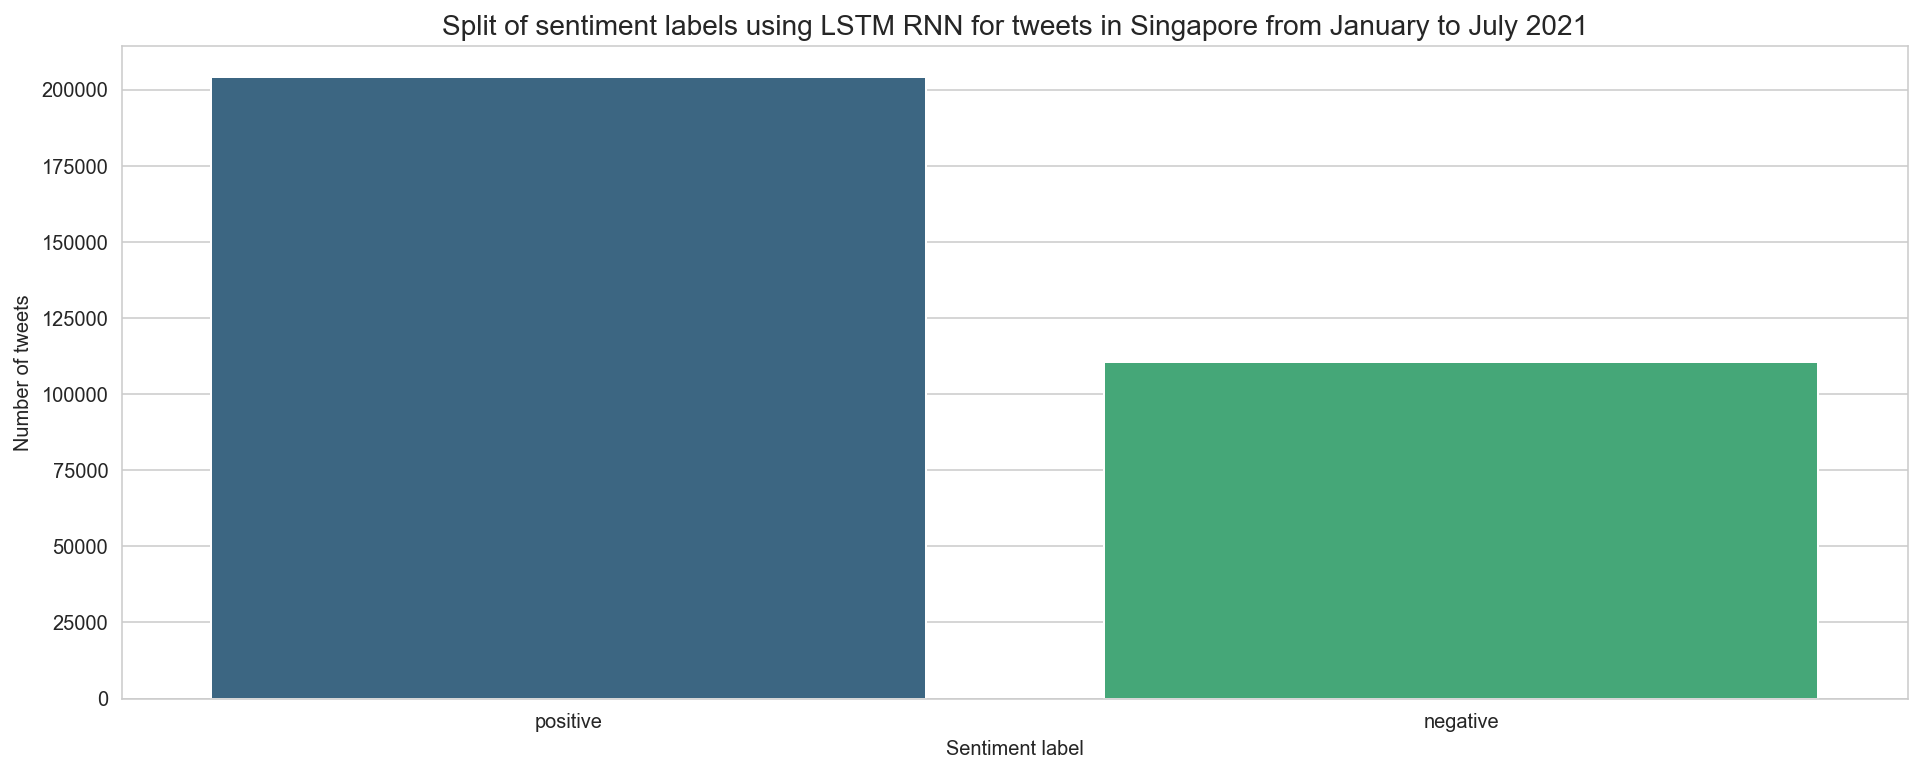

In [31]:
# view the count of sentiment label
plt.figure(figsize=(16,6))
plt.title('Split of sentiment labels using LSTM RNN for tweets in Singapore from January to July 2021', fontsize=14)
ax = sns.countplot(x='lstm_label', data=sg_tweets_lem_df, palette='viridis')
ax.set(xlabel='Sentiment label', ylabel='Number of tweets') 

Compared to VADER and TextBlob, the proportion of positive tweets to negative tweets derived from the LSTM RNN model seems more aligned – i.e. just 1.8 times more positive tweets than negative tweets. 

### 3.4 Comparing across the sentiment labels

To determine which Sentiment Analysis method to be adopted for this project, I will first ascertain the extent of disparity across all three methods, followed by doing a manual comparison of the sentiment labels predicted.

In [33]:
# keeping just the sentiment labels across all 3 methods
sg_tweets_sent_clusters_df = sg_tweets_lem_df[['id', 'date', 'tweet', 'cleaned_tweet', 'lemmatized_tweet',
                                               'sent_label', 'tb_label', 'lstm_label']]

# view the top 5 rows 
sg_tweets_sent_clusters_df.head()

,id,date,tweet,cleaned_tweet,lemmatized_tweet,sent_label,tb_label,lstm_label
0,1355666922210164738,2021-01-31 07:59:15,@zettodot Haha! I know who you feel!,haha know who you feel,haha know who you feel,positive,positive,positive
1,1355666319224397824,2021-01-31 07:56:52,Trained and smashed the pads and bags so hard ...,trained and smashed the pads and bags so hard ...,trained and smashed the pad and bag so hard ye...,positive,negative,negative
2,1355665910283948036,2021-01-31 07:55:14,@zettodot I checking with you all. Excalty lev...,checking with you all excalty level to max al...,checking with you all excalty level to max als...,positive,positive,positive
3,1355664963931570178,2021-01-31 07:51:29,Breakfast https://t.co/gN80tfjySA,breakfast,breakfast,positive,positive,positive
4,1355664076957880320,2021-01-31 07:47:57,@zettodot Don't give up until the event end!,don give up until the event end,don give up until the event end,positive,positive,negative


In [34]:
# view the breakdown between positive and negative values for sent_label, tb_label, and lstm_label
def pos_neg_split(df):
    print('Breakdown for VADER')
    print(df['sent_label'].value_counts(normalize=True))
    print('\n')
    
    print('Breakdown for TextBlob')
    print(df['tb_label'].value_counts(normalize=True))
    print('\n')
    
    print('Breakdown for LSTM')
    print(df['lstm_label'].value_counts(normalize=True))

# apply the df
pos_neg_split(sg_tweets_sent_clusters_df)

Breakdown for VADER
positive    0.798945
negative    0.201055
Name: sent_label, dtype: float64


Breakdown for TextBlob
positive    0.841234
negative    0.158766
Name: tb_label, dtype: float64


Breakdown for LSTM
positive    0.648689
negative    0.351311
Name: lstm_label, dtype: float64


Based on the breakdown between positive and negative labels, it can be observed that TextBlob has classified the highest number of tweets as positive (84.1%), as compared to VADER (79.9%) and LSTM (64.9%).

In [35]:
# store the labels in a separate dataframe
sg_tweets_sent_clusters_only_df = sg_tweets_sent_clusters_df[['sent_label', 'tb_label', 'lstm_label']]

# check all columns against the first column (sent_label)
sg_tweets_sent_clusters_only_df.eq(sg_tweets_sent_clusters_only_df.iloc[:,0], axis=0).head()

,sent_label,tb_label,lstm_label
0,True,True,True
1,True,False,False
2,True,True,True
3,True,True,True
4,True,True,False


In [36]:
# check if the tb_label and lstm_label columns are aligned to sent_label
sg_tweets_sent_clusters_only_df.eq(sg_tweets_sent_clusters_only_df.iloc[:,0], axis=0).all(1).value_counts()

True     180646
False    133930
dtype: int64

By comparison, there are 133,930 tweets in which the labels detected across the three methods are not aligned (i.e. some tweets are detected to be positive, while others are negative). More than half of the tweets – 180,646 tweets – have the same labels across all three methods. 

I will now proceed to manually inspect a portion of the rows (six rounds of 10 rows each), to determine the sentiment analysis method that can be utilised for visualization. 

#### 3.4.1 Round 1 of Inspection

In [37]:
# view the random 10 rows (first set)
sg_tweets_sent_clusters_df.iloc[500:510,:]

,id,date,tweet,cleaned_tweet,lemmatized_tweet,sent_label,tb_label,lstm_label
500,1355514853603958791,2021-01-30 21:55:00,HUNGRY,hungry,hungry,positive,positive,negative
501,1355514281236725766,2021-01-30 21:52:43,Talking to some people makes me feel I’m just ...,talking to some people makes me feel m just wa...,talking to some people make me feel m just was...,negative,positive,negative
502,1355514223837597702,2021-01-30 21:52:29,Melecet not funny sia. Istg,melecet not funny sia istg,melecet not funny sia istg,negative,negative,negative
503,1355514204728426511,2021-01-30 21:52:25,Reply with your zodiac and check ur dm (i will...,reply with your zodiac and check ur dm will on...,reply with your zodiac and check ur dm will on...,positive,positive,positive
504,1355513961525858310,2021-01-30 21:51:27,@IshakBb Hurm... hard to say but yes 😂,hurm hard to say but yes,hurm hard to say but yes,positive,negative,positive
505,1355513915904409601,2021-01-30 21:51:16,Allahu Akbar Subhanallah Alhamdulillah A perso...,allahu akbar subhanallah alhamdulillah person ...,allahu akbar subhanallah alhamdulillah person ...,positive,positive,positive
506,1355513689512661003,2021-01-30 21:50:22,exactly wtf doesn't make any sense whatsoever,exactly wtf doesn make any sense whatsoever,exactly wtf doesn make any sense whatsoever,negative,negative,negative
507,1355513643161452545,2021-01-30 21:50:11,"This chap looks like the quintessential ""Papa ...",this chap looks like the quintessential papa n...,this chap look like the quintessential papa ne...,negative,negative,positive
508,1355513579743576066,2021-01-30 21:49:56,HOLY SHIT I'M IN SWEDEN,holy shit m in sweden,holy shit m in sweden,negative,negative,negative
509,1355513483903737861,2021-01-30 21:49:33,"but i suck at replying, btw, just sayibg",but suck at replying btw just sayibg,but suck at replying btw just sayibg,negative,positive,negative


By manually inspecting the tweets, the following showcases how I will classify the sentiment of the tweets: 
- Index 500: Positive
- Index 501: Negative
- Index 502: Negative
- Index 503: Positive
- Index 504: Positive
- Index 505: Positive
- Index 506: Negative
- Index 507: Negative
- Index 508: Positive
- Index 509: Negative


Results from Round 1 of inspection: 
- VADER: 9 are aligned
- TextBlob: 6 are aligned
- LSTM: 7 are aligned 

#### 3.4.2 Round 2 of Inspection

In [38]:
# view the random 10 rows (second) set)
sg_tweets_sent_clusters_df.iloc[50000:50010,:]

,id,date,tweet,cleaned_tweet,lemmatized_tweet,sent_label,tb_label,lstm_label
50000,1345334010096934912,2021-01-02 19:39:57,@mofumofu_dance I ordered the 33 &amp; 34 that...,ordered the amp that you ve recommended but h...,ordered the amp that you ve recommended but ha...,positive,positive,negative
50001,1345333992120340480,2021-01-02 19:39:53,I'm at Douchebag https://t.co/XGUfCfocfz htt...,i at douchebag,i at douchebag,negative,positive,negative
50002,1345333607657664512,2021-01-02 19:38:21,"i dunno what happen to me today,, i'm spending...",i dunno what happen to me today m spending my ...,i dunno what happen to me today m spending my ...,positive,negative,negative
50003,1345333547599417346,2021-01-02 19:38:07,The showdown between @BalajiDossOffl and @Aari...,the showdown between and please kindly bring b...,the showdown between and please kindly bring b...,positive,positive,positive
50004,1345333519476617221,2021-01-02 19:38:00,The President is meant to represent us all in ...,the president is meant to represent us all in ...,the president is meant to represent u all in n...,positive,positive,positive
50005,1345333413457215488,2021-01-02 19:37:35,SAME SIS 🥲🤣,same sis,same si,positive,positive,positive
50006,1345333391239958528,2021-01-02 19:37:30,nice i just woke up,nice just woke up,nice just woke up,positive,positive,positive
50007,1345333270272069632,2021-01-02 19:37:01,Good. Stay this way .,good stay this way,good stay this way,positive,positive,positive
50008,1345333257227812866,2021-01-02 19:36:58,Thumbbreaker Barnes is the best brain Ravi has...,thumbbreaker barnes is the best brain ravi has...,thumbbreaker barnes is the best brain ravi ha ...,positive,positive,positive
50009,1345332877857226752,2021-01-02 19:35:27,"Wehhhh... i dont know from whom n why, but tet...",wehhhh dont know from whom why but tetiba dpt ...,wehhhh dont know from whom why but tetiba dpt ...,positive,positive,negative


By manually inspecting the tweets, the following showcases how I will classify the sentiment of the tweets: 
- Index 50000: Positive
- Index 50001: Negative
- Index 50002: Negative
- Index 50003: Positive
- Index 50004: Negative
- Index 50005: Positive
- Index 50006: Positive
- Index 50007: Positive
- Index 50008: Positive
- Index 50009: Negative


Results from Round 2 of inspection: 
- VADER: 7 are aligned
- TextBlob: 7 are aligned
- LSTM: 8 are aligned 

#### 3.4.3 Round 3 of Inspection

In [39]:
# view the random 10 rows (third set)
sg_tweets_sent_clusters_df.iloc[100000:100010,:]

,id,date,tweet,cleaned_tweet,lemmatized_tweet,sent_label,tb_label,lstm_label
100000,1356581477237030912,2021-02-02 20:33:22,"""Wired earphones "" in #Singapore #Singapore h...",wired earphones in,wired earphone in,positive,positive,positive
100001,1356581059308228609,2021-02-02 20:31:43,Say it louder for the people in the back please,say it louder for the people in the back please,say it louder for the people in the back please,positive,positive,negative
100002,1356580756382908417,2021-02-02 20:30:31,@ohaizat Yooo wtf this is super poggers!,yooo wtf this is super poggers,yooo wtf this is super poggers,positive,negative,positive
100003,1356580664498294784,2021-02-02 20:30:09,I stand with all the people who are participat...,i stand with all the people who are participat...,i stand with all the people who are participat...,negative,negative,positive
100004,1356580537519861760,2021-02-02 20:29:38,@amritat @PrachiJainK @guptpuneet Thanks for y...,thanks for your partnership and your leadersh...,thanks for your partnership and your leadershi...,positive,positive,positive
100005,1356580329159499777,2021-02-02 20:28:49,Love meeting new people? We're looking for a M...,love meeting new people we re looking for memb...,love meeting new people we re looking for memb...,positive,positive,negative
100006,1356580298662629376,2021-02-02 20:28:41,The Dillinger Escape Plan really fucking rocks...,the dillinger escape plan really fucking rocks...,the dillinger escape plan really fucking rock ...,positive,positive,negative
100007,1356580057293066243,2021-02-02 20:27:44,It is Andre Villas-Goas,it is andre villas goas,it is andre villa goa,positive,positive,positive
100008,1356580027647860736,2021-02-02 20:27:37,Just posted a photo @ Orchard Road https://t....,just posted photo orchard road,just posted photo orchard road,positive,positive,positive
100009,1356580026729201664,2021-02-02 20:27:37,@pbpua of course not; the number of times I’ve...,of course not the number of times ve cited him,of course not the number of time ve cited him,negative,positive,positive


By manually inspecting the tweets, the following showcases how I will classify the sentiment of the tweets: 
- Index 100000: Positive
- Index 100001: Negative
- Index 100002: Positive
- Index 100003: Positive
- Index 100004: Positive
- Index 100005: Positive
- Index 100006: Negative
- Index 100007: Positive
- Index 100008: Positive
- Index 100009: Positive


Results from Round 3 of inspection: 
- VADER: 6 are aligned
- TextBlob: 6 are aligned
- LSTM: 9 are aligned 

#### 3.4.4 Round 4 of Inspection

In [40]:
# view the random 10 rows (fourth set)
sg_tweets_sent_clusters_df.iloc[200000:200010,:]

,id,date,tweet,cleaned_tweet,lemmatized_tweet,sent_label,tb_label,lstm_label
200000,1398151607162793987,2021-05-28 13:38:14,@ikenotbrain More cat more komitmen,more cat more komitmen,more cat more komitmen,positive,positive,positive
200001,1398151297002479618,2021-05-28 13:37:00,But Taiwan is a country! Shame for apologising!,but taiwan is country shame for apologising,but taiwan is country shame for apologising,negative,positive,positive
200002,1398151227318226948,2021-05-28 13:36:43,Can copy his actions to cook this seabass. Bur...,can copy his actions to cook this seabass burn...,can copy his action to cook this seabass burn ...,positive,positive,negative
200003,1398150850300694528,2021-05-28 13:35:13,@parrysingh @criteo Started with a birdie on t...,started with birdie on the th,started with birdie on the th,positive,positive,positive
200004,1398150814296727557,2021-05-28 13:35:05,My family doctor in Singapore basically assume...,my family doctor in singapore basically assume...,my family doctor in singapore basically assume...,positive,positive,positive
200005,1398150275441905666,2021-05-28 13:32:56,I haven’t seen it yet!!! Gonna take a break (a...,i haven seen it yet gonna take break after the...,i haven seen it yet gon na take break after th...,positive,positive,positive
200006,1398149938995859462,2021-05-28 13:31:36,"@alterkitect Me, too.",me too,me too,positive,positive,negative
200007,1398149884994334722,2021-05-28 13:31:23,Just posted a photo @ Singapore https://t.co/...,just posted photo singapore,just posted photo singapore,positive,positive,positive
200008,1398149501735510016,2021-05-28 13:29:52,"The danger of Singapore twitter woke, cancel m...",the danger of singapore twitter woke cancel mo...,the danger of singapore twitter woke cancel mo...,negative,negative,negative
200009,1398149234684276741,2021-05-28 13:28:48,"Just posted a photo @ Sentosa , Singapore htt...",just posted photo sentosa singapore,just posted photo sentosa singapore,positive,positive,positive


By manually inspecting the tweets, the following showcases how I will classify the sentiment of the tweets: 
- Index 200000: Positive
- Index 200001: Negative
- Index 200002: Negative
- Index 200003: Positive
- Index 200004: Negative
- Index 200005: Positive
- Index 200006: Positive
- Index 200007: Positive
- Index 200008: Negative
- Index 200009: Positive


Results from Round 4 of inspection: 
- VADER: 8 are aligned
- TextBlob: 7 are aligned
- LSTM: 7 are aligned 

#### 3.4.5 Round 5 of Inspection

In [41]:
# view the random 10 rows (fifth set)
sg_tweets_sent_clusters_df.iloc[300000:300010,:]

,id,date,tweet,cleaned_tweet,lemmatized_tweet,sent_label,tb_label,lstm_label
300000,1414476885061419008,2021-07-12 14:49:03,"I'm at Clemenceau Bridge in River Valley, Sing...",i at clemenceau bridge in river valley singapore,i at clemenceau bridge in river valley singapore,positive,positive,positive
300001,1414476610284113920,2021-07-12 14:47:58,me n who,me who,me who,positive,positive,positive
300002,1414476520526024707,2021-07-12 14:47:36,Met once but i have my own.....was taking it o...,met once but have my own was taking it out fro...,met once but have my own wa taking it out from...,positive,positive,negative
300003,1414475815182503941,2021-07-12 14:44:48,"@bytebot Yes, i often seen @googlechrome unsta...",yes often seen unstable on macos my workaroun...,yes often seen unstable on macos my workaround...,positive,positive,negative
300004,1414475750661525504,2021-07-12 14:44:33,what a week😍,what week,what week,positive,positive,negative
300005,1414475598190157831,2021-07-12 14:43:56,Managed to get weekend slots for a game two Mo...,managed to get weekend slots for game two mond...,managed to get weekend slot for game two monda...,positive,negative,negative
300006,1414475576354693124,2021-07-12 14:43:51,Just posted a photo @ CHIJMES https://t.co/ft...,just posted photo chijmes,just posted photo chijmes,positive,positive,positive
300007,1414475560957272066,2021-07-12 14:43:48,Everyday’s hero #streetphotography #fujifilm...,everyday hero,everyday hero,positive,negative,positive
300008,1414475515033911296,2021-07-12 14:43:37,Ok sis need to save up for a new gold ring and...,ok sis need to save up for new gold ring and g...,ok si need to save up for new gold ring and go...,positive,positive,positive
300009,1414474347448705034,2021-07-12 14:38:58,Newly-Renovated Hyatt Regency Tokyo Bay opens ...,newly renovated hyatt regency tokyo bay opens ...,newly renovated hyatt regency tokyo bay open w...,positive,positive,positive


By manually inspecting the tweets, the following showcases how I will classify the sentiment of the tweets: 
- Index 300000: Positive
- Index 300001: Positive
- Index 300002: Positive
- Index 300003: Negative
- Index 300004: Positive
- Index 300005: Positive
- Index 300006: Positive
- Index 300007: Positive
- Index 300008: Positive
- Index 300009: Positive


Results from Round 5 of inspection: 
- VADER: 9 are aligned
- TextBlob: 7 are aligned
- LSTM: 7 are aligned

#### 3.4.6 Round 6 of Inspection

In [42]:
# view the random 10 rows (sixth set)
sg_tweets_sent_clusters_df.iloc[310000:310010,:]

,id,date,tweet,cleaned_tweet,lemmatized_tweet,sent_label,tb_label,lstm_label
310000,1411685381615984644,2021-07-04 21:56:37,"@melozyx Right now it’s not open, but it’ll be...",right now it not open but it ll be in maybe m...,right now it not open but it ll be in maybe mo...,positive,positive,positive
310001,1411685189302972416,2021-07-04 21:55:51,@EuroGuido New New Amsterdam 😎,new new amsterdam,new new amsterdam,positive,positive,positive
310002,1411685023841882120,2021-07-04 21:55:12,In love with my new bike❤️😍,in love with my new bike,in love with my new bike,positive,positive,positive
310003,1411684866337349634,2021-07-04 21:54:34,"Just got vaccinated yesterday, feeling good",just got vaccinated yesterday feeling good,just got vaccinated yesterday feeling good,positive,positive,positive
310004,1411684855046238214,2021-07-04 21:54:31,There we go. 5 second penalty for Checo. At le...,there we go second penalty for checo at least ...,there we go second penalty for checo at least ...,negative,positive,positive
310005,1411684338517774339,2021-07-04 21:52:28,If Checo doesn’t get a 5 second penalty for th...,if checo doesn get second penalty for that the...,if checo doesn get second penalty for that the...,negative,positive,negative
310006,1411684324869500928,2021-07-04 21:52:25,yoasobi’s live concept is really impressive,yoasobi live concept is really impressive,yoasobi live concept is really impressive,positive,positive,positive
310007,1411684266015039488,2021-07-04 21:52:11,Here,here,here,positive,positive,positive
310008,1411684087601844228,2021-07-04 21:51:28,"Nothing is logical in this PN government , Pah...",nothing is logical in this pn government pahan...,nothing is logical in this pn government pahan...,positive,positive,negative
310009,1411684074511474692,2021-07-04 21:51:25,I love Vitas0y #HKPoliceState https://t.co/Qt...,i love vitas,i love vitas,positive,positive,positive


By manually inspecting the tweets, the following showcases how I will classify the sentiment of the tweets: 
- Index 310000: Positive
- Index 310001: Positive
- Index 310002: Positive
- Index 310003: Positive
- Index 310004: Positive
- Index 310005: Negative
- Index 310006: Positive
- Index 310007: Positive
- Index 310008: Negative
- Index 310009: Positive


Results from Round 6 of inspection: 
- VADER: 8 are aligned
- TextBlob: 8 are aligned
- LSTM: 10 are aligned

#### 3.4.7 Rounding up the Inspections

In [43]:
# create a dataframe to store results from the manual inspection
inspection = {'name': ['vader', 'textblob', 'lstm'], 
              'round_1': [9,6,7],
              'round_2': [7,7,8],
              'round_3': [6,6,9], 
              'round_4': [8,7,7],
              'round_5': [9,7,7],
              'round_6': [8,8,10]}

inspection_df = pd.DataFrame(data=inspection).set_index('name')
inspection_df.head()

,round_1,round_2,round_3,round_4,round_5,round_6
name,,,,,,
vader,9,7,6,8,9,8
textblob,6,7,6,7,7,8
lstm,7,8,9,7,7,10


In [44]:
# sum up the number of alignment per method
inspection_df['total'] = inspection_df.sum(axis=1)

# view the dataframe
inspection_df

,round_1,round_2,round_3,round_4,round_5,round_6,total
name,,,,,,,
vader,9,7,6,8,9,8,47
textblob,6,7,6,7,7,8,41
lstm,7,8,9,7,7,10,48


Based on the above comparison, it can be observed that LSTM RNN has the highest alignment in terms of deriving the sentiment of a tweet (as compared to my interpretation), followed by VADER and lastly Textblob. While further comparisons can be made (i.e. increasing the sampling frequency and with larger sample sizes), for the purpose of this analysis, I will use the sentiment labels derived from the LSTM RNN model. 

### 3.5 Visualizing sentiment of tweets over time

Using the sentiment labels derived from the LSTM RNN model, let's visualize how the sentiment has changed over the past seven months. 

In [97]:
# view proportion of sentiments
print('The overall distribution of the sentiments of the tweets from January to July 2021 is as follows:')
print(sg_tweets_lem_df['lstm_label'].value_counts(normalize=True))
print('\n')
print('The mmonthly distribution of the sentiments of the tweets from January to July 2021 is as follows:')
print(sg_tweets_lem_df.groupby('month')['lstm_label'].value_counts(normalize=True))

The overall distribution of the sentiments of the tweets from January to July 2021 is as follows:
positive    0.648689
negative    0.351311
Name: lstm_label, dtype: float64


The mmonthly distribution of the sentiments of the tweets from January to July 2021 is as follows:
month  lstm_label
1      positive      0.651038
       negative      0.348962
2      positive      0.647251
       negative      0.352749
3      positive      0.638160
       negative      0.361840
4      positive      0.648534
       negative      0.351466
5      positive      0.658394
       negative      0.341606
6      positive      0.633497
       negative      0.366503
7      positive      0.664798
       negative      0.335202
Name: lstm_label, dtype: float64


[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul')]

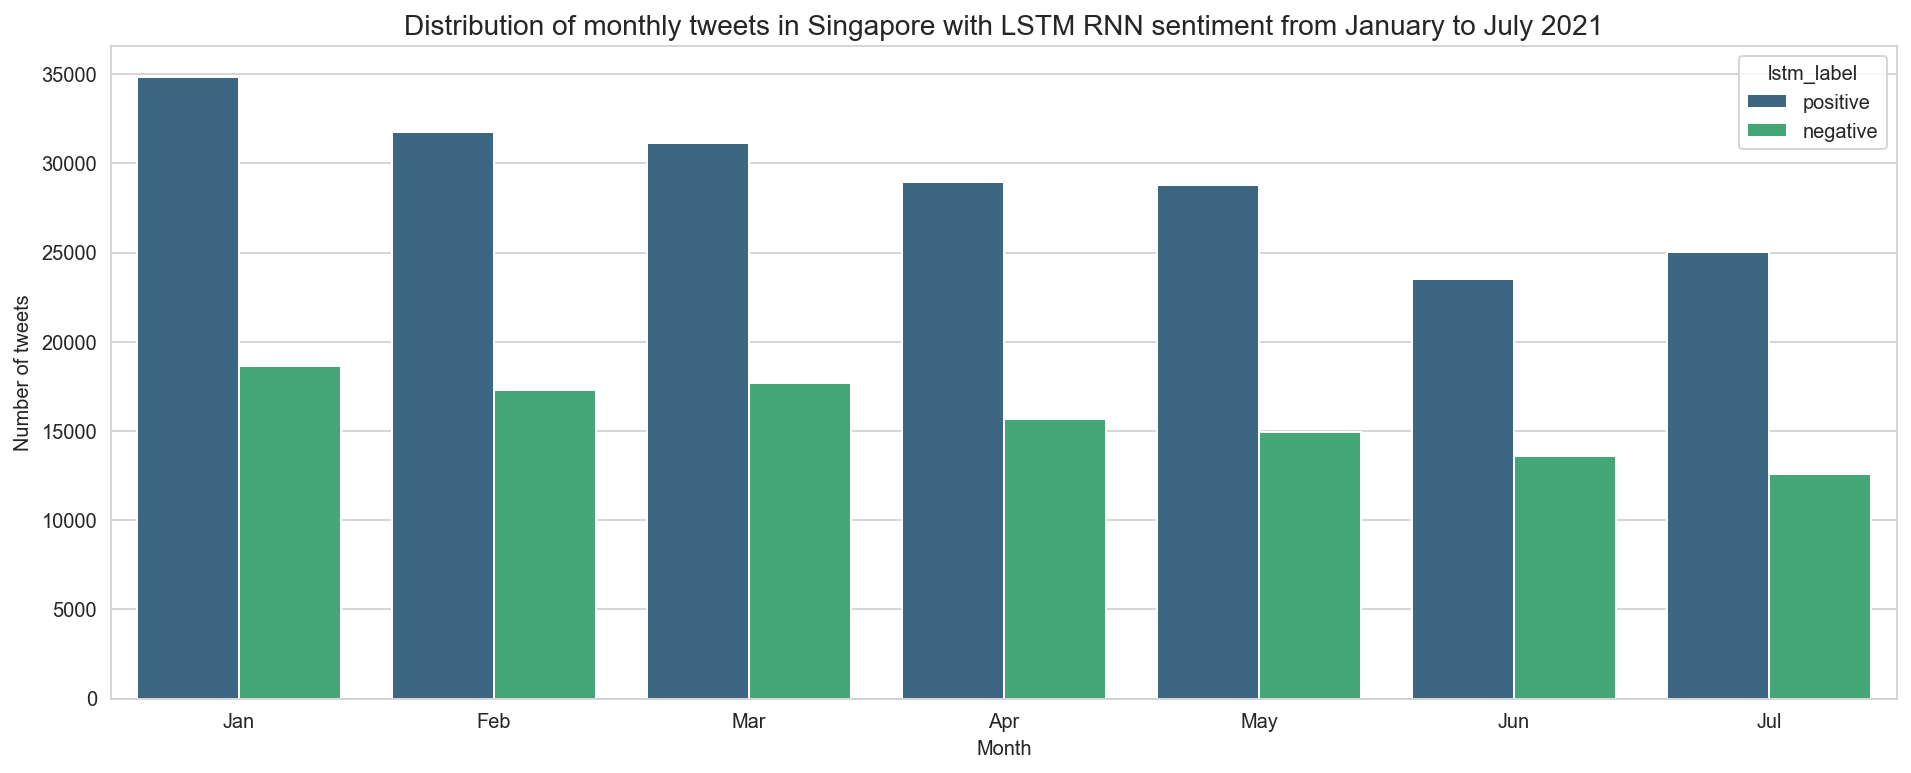

In [106]:
# view the distribution of sentiment of tweets over months
plt.figure(figsize=(16,6))
plt.title('Distribution of monthly tweets in Singapore with LSTM RNN sentiment from January to July 2021', fontsize=14)
ax = sns.countplot(x='month', data=sg_tweets_lem_df, hue='lstm_label', palette='viridis')
ax.set(xlabel='Month', ylabel='Number of tweets')  
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']
ax.set_xticklabels(months)

In the first seven months of 2021, it can be observed that overall, the proportion of positive tweets (64.9%) is close to 2x that of negative tweets (35.1%). This indicates that despite the prevalence of COVID-19 virus and various social issues, the community seems to have remained positive. 

Let's look at the weekly breakdown – but first let's create a new column for `week`.

In [153]:
# convert the date column to datetime 
sg_tweets_lem_df['date'] = pd.to_datetime(sg_tweets_lem_df['date'])

# add in a new column for week
sg_tweets_lem_df['week'] = sg_tweets_lem_df['date'].dt.isocalendar().week.astype('int64')

# view the values present in the week
sg_tweets_lem_df['week'].value_counts()

6     14027
1     13020
5     12733
2     12672
7     12445
11    12002
3     11915
12    11668
15    11065
14    10945
10    10934
9     10702
16    10558
19    10471
20    10229
21    10094
18     9968
13     9943
8      9861
4      9851
24     9179
27     9074
23     9060
28     8813
29     8684
17     8461
25     8324
22     7819
26     7671
30     6353
53     6035
Name: week, dtype: int64

It's odd that there's a week 53 – this may be a classification issue. Let's look at the actual dates of the tweets classified under week 53.

In [151]:
# view tweets in week 53
sg_tweets_lem_df[sg_tweets_lem_df['week']==53].head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label,tb_polarity,tb_subjectivity,tb_label,lstm_label,week
47458,1345761815129587713,2021-01-03 23:59:54,i need to pick up skills of folding xtra fast,en,[],212558215,AM15HA,0,0,0,Singapore,2021-01-03,1,2021,23,45,10,0,0,i need to pick up skills of folding xtra fast,i need to pick up skill of folding xtra fast,0.0000,positive,0.20,0.600,positive,negative,53
47459,1345761798947889153,2021-01-03 23:59:50,Sometimes when i wanna fall asleep ..i look at...,en,[],1174647267782848512,ardyyyanugrah,0,0,0,Singapore,2021-01-03,1,2021,23,109,23,0,1,sometimes when wanna fall asleep look at the r...,sometimes when wan na fall asleep look at the ...,0.9022,positive,0.15,0.375,positive,positive,53
47460,1345761685194248194,2021-01-03 23:59:23,I've cried for all what happen ..I will be back,en,[],324955521,RCBLeadVocalist,1,0,0,Singapore,2021-01-03,1,2021,23,47,10,0,0,i ve cried for all what happen will be back,i ve cried for all what happen will be back,-0.3818,negative,0.00,0.000,positive,negative,53
47461,1345761490154864641,2021-01-03 23:58:36,Tho I missed the thai milk ice cream from mcd ...,en,[],439039056,fzybear,0,0,0,Singapore,2021-01-03,1,2021,23,153,29,0,0,tho missed the thai milk ice cream from mcd bu...,tho missed the thai milk ice cream from mcd bu...,0.7783,positive,0.35,0.550,positive,positive,53
47462,1345761472123609088,2021-01-03 23:58:32,@nnisatuduatiga @Crypto_Guy_UK @MattDDyer @maq...,en,[],29917270,ColinMiles,3,0,0,Singapore,2021-01-03,1,2021,23,73,9,0,4,thank you as well,thank you a well,0.5574,positive,0.00,0.000,positive,positive,53


Turns out that tweets identified in week 53 are from 1 January 2021 to 3 January 2021. Let's classify these tweets as under week 0 instead.

In [156]:
# map week 53 tweets to week 0
sg_tweets_lem_df['week'] = sg_tweets_lem_df['week'].replace(53,0)

# view tweets in week 0
sg_tweets_lem_df[sg_tweets_lem_df['week']==0].head()

,id,date,tweet,language,hashtags,user_id,username,nlikes,nreplies,nretweets,near,date_only,month,year,hour,char_length,word_count,num_hashtag,num_mentions,cleaned_tweet,lemmatized_tweet,sent_compound,sent_label,tb_polarity,tb_subjectivity,tb_label,lstm_label,week
47458,1345761815129587713,2021-01-03 23:59:54,i need to pick up skills of folding xtra fast,en,[],212558215,AM15HA,0,0,0,Singapore,2021-01-03,1,2021,23,45,10,0,0,i need to pick up skills of folding xtra fast,i need to pick up skill of folding xtra fast,0.0000,positive,0.20,0.600,positive,negative,0
47459,1345761798947889153,2021-01-03 23:59:50,Sometimes when i wanna fall asleep ..i look at...,en,[],1174647267782848512,ardyyyanugrah,0,0,0,Singapore,2021-01-03,1,2021,23,109,23,0,1,sometimes when wanna fall asleep look at the r...,sometimes when wan na fall asleep look at the ...,0.9022,positive,0.15,0.375,positive,positive,0
47460,1345761685194248194,2021-01-03 23:59:23,I've cried for all what happen ..I will be back,en,[],324955521,RCBLeadVocalist,1,0,0,Singapore,2021-01-03,1,2021,23,47,10,0,0,i ve cried for all what happen will be back,i ve cried for all what happen will be back,-0.3818,negative,0.00,0.000,positive,negative,0
47461,1345761490154864641,2021-01-03 23:58:36,Tho I missed the thai milk ice cream from mcd ...,en,[],439039056,fzybear,0,0,0,Singapore,2021-01-03,1,2021,23,153,29,0,0,tho missed the thai milk ice cream from mcd bu...,tho missed the thai milk ice cream from mcd bu...,0.7783,positive,0.35,0.550,positive,positive,0
47462,1345761472123609088,2021-01-03 23:58:32,@nnisatuduatiga @Crypto_Guy_UK @MattDDyer @maq...,en,[],29917270,ColinMiles,3,0,0,Singapore,2021-01-03,1,2021,23,73,9,0,4,thank you as well,thank you a well,0.5574,positive,0.00,0.000,positive,positive,0


In [158]:
# create variables to store the positive and negative tweets
pos_label = sg_tweets_lem_df[sg_tweets_lem_df['lstm_label']=='positive']
pos_label_df = pos_label['week'].value_counts().rename_axis('week').to_frame('count')

neg_label = sg_tweets_lem_df[sg_tweets_lem_df['lstm_label']=='negative']
neg_label_df = neg_label['week'].value_counts().rename_axis('week').to_frame('count')

[Text(0.5, 0, 'Week of year'), Text(0, 0.5, 'Number of tweets')]

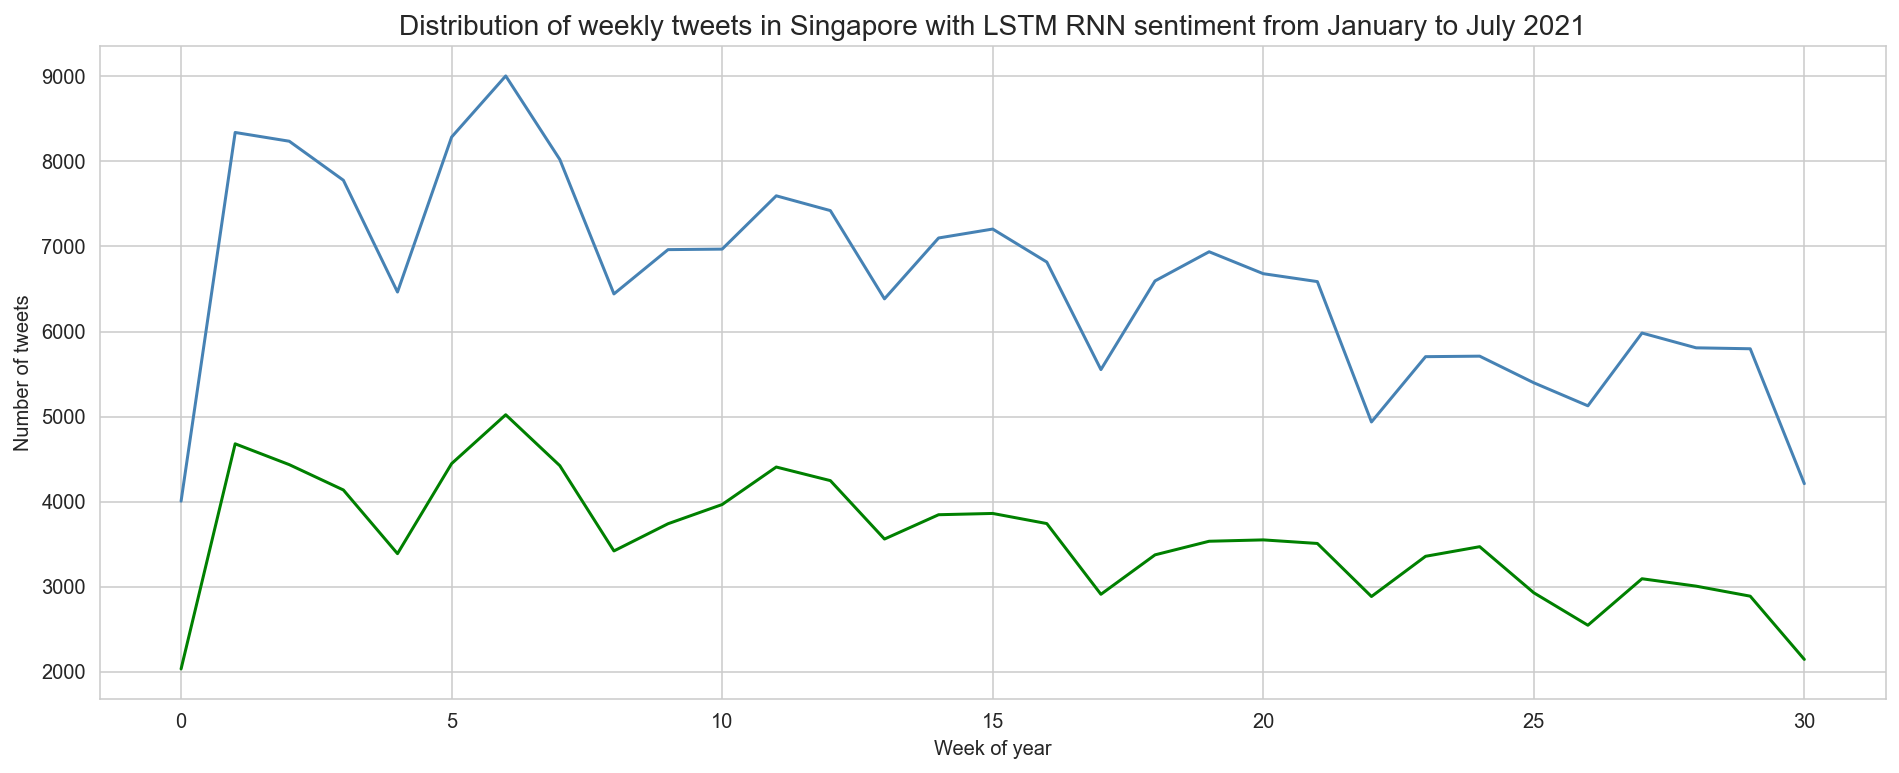

In [162]:
# plot the weekly trend for positive and negative tweets
plt.figure(figsize=(16,6))
plt.title('Distribution of weekly tweets in Singapore with LSTM RNN sentiment from January to July 2021', fontsize=14)
ax = sns.lineplot(data=pos_label_df, x='week', y='count', color='steelblue')
ax = sns.lineplot(data=neg_label_df, x='week', y='count', color='green')
ax.set(xlabel = 'Week of year', ylabel = 'Number of tweets')

From the distribution of the weekly tweets, it can be observed that there are certain time periods in which the number of positive tweets is much higher than that of the negative tweets, such as between week 1 to week 7. From week 20 onwards, the gap between the positive and negative tweets seems to be inching closer together.

Let's look at some of the major announcements and events that have occurred in Singapore in the past seven months, as well as notable events around the world:
- **January 2021** (week 0 to week 4): 
    - Phase 3 reopening of Singapore from 28 December 2021, where group size for gatherings was increased from 5 to 8 persons. 
    - Vaccination for healthcare workers began on 30 December 2021.
    
    
- **February 2021** (week 5 to week 8): 
    - Miltary coup in Myanmar began from 1 February 2021.  
    - Seniors could receive their COVID-19 vaccinations from 22 February 2021 onwards. 
    
    
- **March 2021** (week 9 to week 13):
    - The Ministry of Health (MOH) announced on 8 March 2021 that vaccinations for people aged 60 to 69 would be brought forward from end-March, with an increase in supply of vaccine stocks in Singapore.
    - MOH announced on 24 March 2021 that more people could return to work from 5 April 2021 onwards to boost the central business district (CBD) and industrial park sector to 80%.


- **April 2021** (week 14 to week 17): 
    - MOH announced on 22 April 2021 that only the TraceTogether app/token would be accepted for SafeEntry checking-in from 1 June 2021 onwards, at all high-risk avenues such as shopping malls, workplaces, schools, places of worship, etc. 
    - Singapore and Hong Kong announced on 26 April 2021 that the air travel bubble between both cities would re-launch on 26 May 2021.


- **May 2021** (week 18 to week 21): 
    - MOH announced on 4 May 2021 that Singapore would temporarily revert to Phase 2 from 8 to 30 May 2021 due to multiple virulent strains worldwide.
    - With the recent surge of cases in the community, MOH announced on 14 May 2021 that Singapore would enter Phase 2 (Heightened Alert) from 16 May to 13 June 2021.
    - The 2021 Premier League Season, which started on 12 September 2020, officially ended on 23 May 2021.  


- **June 2021** (week 22 to week 26):
    - Mass vaccination exercise for all Singapore and permanent residents (aged 12 and above) would begin on 1 June 2021. Work from home and home-based learning would fully cease when herd immunity is achieved. 
    - MOH announced on 10 June 2021 and 18 June 2021 respectively that Singapore would move back to Phase 3 (Heightened Alert) in two steps on 14 June 2021 – the limit for social gathering would be increased from 2 to 5, while dining-in for up to 2 persons would resume on 21 June 2021. 


- **July 2021** (week 27 to week 30): 
    - MOH announced on 7 July 2021 that from 12 July 2021, dining-in and social gatherings at the workplace in groups of up to 5 would resume, though work from home remained the default.
    - Tightening of community measures under Phase 2 (Heightened Alert) would occur from 19 July 2021 through 8 August 2021, due to the growing COVID-19 cases linked to the Jurong Fishery Port and KTV clusters.

Comparing to the timeline of major announcements and events, it seems that we will observe an increase in the number of positive tweets when happy and cheerful events occur, such as: 
- Phase 3 reopening of Singapore where people are able to dine-in at restaurants and have gatherings in bigger groups.
- Festive seasons and celebrations such as Chinese New Year and Valentine's Day.
- Positive celebrity news, such as Lee Min Ho's 15th anniversity in the showbiz and new songs from South Korean boyband BTS. 

As for negative tweets, they seem to rise when:
- Increasing number of locals who are protesting against the military coup in Myanmar but ends up being attacked by the security forces.
- Growing number of confirmed COVID-19 cases and expanding COVID-19 clusters in Singapore. 
- MOH announcing that Singapore will return back to Phase 2 or Phase 2 (heightened alert), with restrictions on dine-in and group size for social gathering.


In the [next notebook](./04_topic_modelling_and_conclusion.ipynb), I will be conducting a Topic Modelling for the cleaned tweets, to understand what people in Singapore are discussing on Twitter in recent times, and how the sentiments vary with the topics discussed.

Let's save the DataFrame with sentiment labels as a CSV file. 

In [214]:
# export file with sentiment labels as CSV
sg_tweets_lem_df.to_csv('../datasets/sg_tweets_sentiment_wso_2021.csv', index=False)